In [705]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from functions import *
from chi import *
from regressionP import *
from models import *

In [706]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [18]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11840) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
# rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1)

full_dist.head()

,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,經度,緯度,死亡,受傷
0,0.146102,2.120706,-0.146069,1.210906,0.485564,-0.713755,-1.627801,1.771301,-1.697696,-0.917071,1.798967,-0.634220,-1.868211,13.660843,-2.803204
1,1.465217,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,-1.627801,-0.822895,-1.697696,-0.917071,-0.012319,1.111877,0.974928,13.660843,-0.620846
2,-1.173013,2.911514,-0.146069,1.210906,1.164664,-0.713755,1.177412,1.122752,-1.697696,-0.917071,1.798967,-2.459704,-0.633180,13.660843,-2.803204
3,-1.173013,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,-0.225194,-0.822895,0.422707,1.090428,-0.012319,0.936797,1.016777,13.660843,-0.620846
4,1.465217,2.120706,-0.146069,1.210906,1.164664,-0.713755,0.476109,-0.822895,0.422707,-0.917071,1.798967,1.832866,0.186897,13.660843,-2.803204


In [4]:
rbind_data.shape[0] == full_dist.shape[0]

True

In [5]:
def find_ratio(input_data, components) :
    best_comp = {}
    for comp in range(1,components+1):   
        pca = PCA(comp).fit(input_data)
        
        best_comp[comp] = pca.explained_variance_ratio_.sum()
        
    max_comp = max(best_comp, key=best_comp.get)  # 使用 key=best_comp.get 找到最大值的鍵
    print("最佳成分數：", max_comp)
    print("解釋方差比率累計值：", best_comp[max_comp])

lens1 = find_ratio(full_dist, 9)

最佳成分數： 9
解釋方差比率累計值： 0.7979717406234657


In [573]:
lens1 = PCA(10) # 10 最好
lens_result = lens1.fit_transform(X1.to_numpy())

db = DBSCAN(eps=2.7, min_samples=10).fit(lens_result) # 2.7最好、最低2.2
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

n_clusters_

3

In [574]:
noise_mask = labels == -1
noise_rows = rbind_data[noise_mask]

noise_rows.shape

(63, 15)

In [225]:
noise_rows.to_csv('CalculatedData/離群比較/原始22.csv', index=False)

In [219]:
logistic_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]

# denoise_data = rbind_data[~noise_mask]
# origin_X, origin_y = get_clusterN_logit(denoise_data, logistic_lst)

# start_time = time.time()

# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# print(score_origin)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

In [49]:
# data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[data_origin.columns]

# denoise_data_from_mapper = rbind_data.loc[rbind_data[~rbind_data.apply(tuple, axis=1).isin(data_mapper.apply(tuple, axis=1))].index]

# origin_X, origin_y = get_clusterN_logit(denoise_data_from_mapper, logistic_lst)

# import time
# start_time = time.time()

# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# print(score_origin)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

## 比較不同的離群
### 主要依照拓墣的區分方式，道路分析拓墣為15個欄位，而data_mapper是因為分類所以增加欄位

In [707]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始.csv')
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[data_origin.columns]

print(data_origin.shape)
print(data_mapper.shape)

(63, 15)
(131, 15)


In [708]:
overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列进行筛选，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(non_overlapping_rows_origin.shape)
print(non_overlapping_rows_mapper.shape)
print('重複：', overlapping_rows.shape[0])

print(len(overlapping_index_origin) == len(overlapping_index_mapper))
print(overlapping_rows_origin.shape[0] == overlapping_rows_mapper.shape[0])

(10, 15)
(78, 15)
重複： 53
True
True


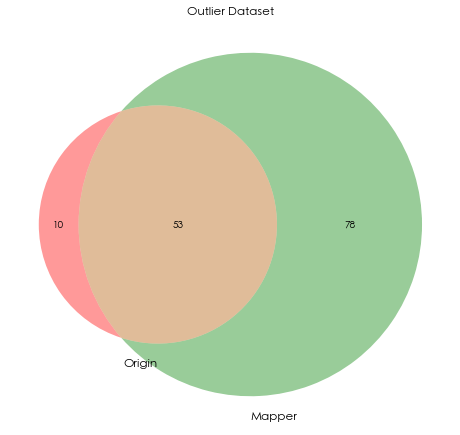

In [582]:
from matplotlib_venn import venn2 # 文氏圖

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

origin_set = set(range(total_origin))
mapper_set = set(range(total_mapper))

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('Outlier Dataset')
plt.show()

### Origin 分群

In [583]:
# origin_X, origin_y = get_clusterN_logit(data_origin, logistic_lst)
# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# cm_origin

### Mapper 分群

In [584]:
# mapper_X, mapper_y = get_clusterN_logit(data_mapper, logistic_lst)
# matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)
# cm_mapper

試圖對三個區塊做PCA，找出overlap群體較為接近哪一個群體

## Mapper vs Overlap

In [585]:
non_overlapping_rows_mapper['type'] = 'mapper'
overlapping_rows['type'] = 'overlap'
data_combined = pd.concat([non_overlapping_rows_mapper, overlapping_rows], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)

full_dist.drop(['type'], axis=1, inplace=True)

In [586]:
X_scaled = sm.add_constant(full_dist)

X_train, X_test, y_train, y_test = train_test_split(full_dist, typedt, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.312983
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  104
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                           14
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.5360
Time:                        21:23:41   Log-Likelihood:                -32.550
converged:                       True   LL-Null:                       -70.152
Covariance Type:            nonrobust   LLR p-value:                 2.171e-10
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
光線名稱                       -0.1059      0.393     -0.270      0.787      -0.875   

In [549]:
cl = full_dist.columns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(full_dist)

# Get the principal components and explained variance
principal_components = pca.components_
explained_variance = pca.explained_variance_ratio_

full_dist['PC1'] = pca_result[:, 0]
full_dist['PC2'] = pca_result[:, 1]
full_dist['PC3'] = pca_result[:, 2]
full_dist['type'] = typedt.astype(str)

loadings_df = pd.DataFrame(principal_components.T, columns=['PC1', 'PC2', 'PC3'], index=cl)

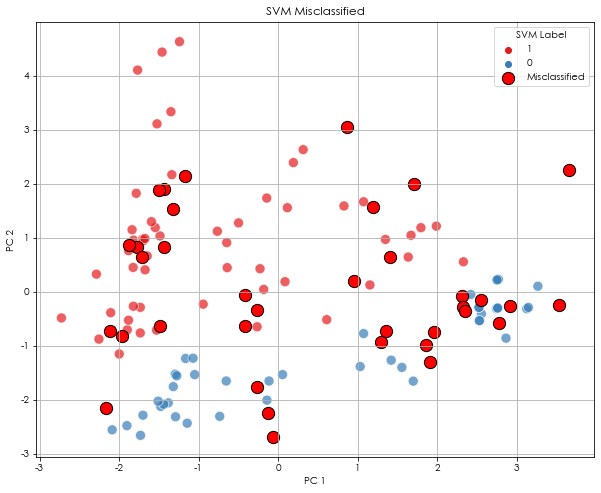

0.7251908396946565

In [550]:
scaler = StandardScaler()
X = scaler.fit_transform(full_dist[['PC1', 'PC2', 'PC3']])

svm = SVC(kernel='linear')
svm.fit(X, full_dist['type'])

full_dist['svm_label'] = svm.predict(X)

full_dist['error'] = full_dist['svm_label'] != full_dist['type']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=full_dist,
    x='PC1',
    y='PC2',
    hue='svm_label',
    palette='Set1',
    s=100,
    edgecolor='w',
    alpha=0.7
)

error_points = full_dist[full_dist['error']]
plt.scatter(
    error_points['PC1'],
    error_points['PC2'],
    color='red',
    edgecolor='black',
    s=150,
    label='Misclassified'
)

plt.title('SVM Misclassified')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='SVM Label')
plt.grid(True)

plt.show()

accuracy = accuracy_score(full_dist['type'], full_dist['svm_label'])
accuracy

## Origin vs Overlap

In [551]:
non_overlapping_rows_origin['type'] = 'origin'
overlapping_rows['type'] = 'overlap'
data_combined = pd.concat([non_overlapping_rows_origin, overlapping_rows], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)
full_dist.drop(['type'], axis=1, inplace=True)

In [552]:
X_scaled = sm.add_constant(full_dist)

X_train, X_test, y_train, y_test = train_test_split(full_dist, typedt, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.369224
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  113
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           14
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.4666
Time:                        20:37:18   Log-Likelihood:                -41.722
converged:                       True   LL-Null:                       -78.215
Covariance Type:            nonrobust   LLR p-value:                 5.530e-10
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
光線名稱                        0.2378      0.301      0.789      0.430      -0.353   

In [553]:
cl = full_dist.columns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(full_dist)

# Get the principal components and explained variance
principal_components = pca.components_
explained_variance = pca.explained_variance_ratio_

full_dist['PC1'] = pca_result[:, 0]
full_dist['PC2'] = pca_result[:, 1]
full_dist['PC3'] = pca_result[:, 2]
full_dist['type'] = typedt.astype(str)

loadings_df = pd.DataFrame(principal_components.T, columns=['PC1', 'PC2', 'PC3'], index=cl)

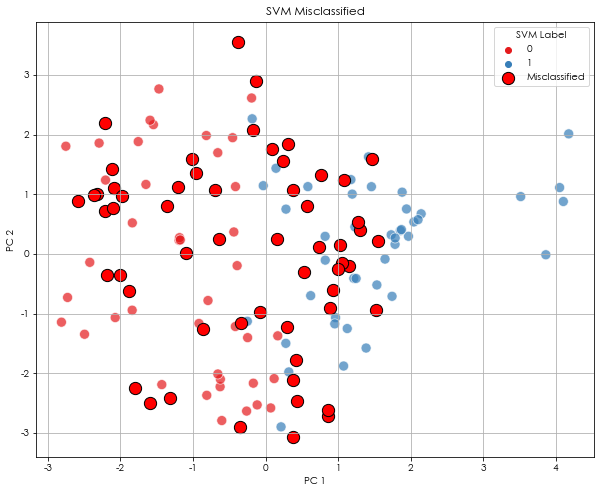

0.5985915492957746

In [554]:
from sklearn.svm import SVC

scaler = StandardScaler()
X = scaler.fit_transform(full_dist[['PC1', 'PC2', 'PC3']])

svm = SVC(kernel='linear')
svm.fit(X, full_dist['type'])

full_dist['svm_label'] = svm.predict(X)

full_dist['error'] = full_dist['svm_label'] != full_dist['type']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=full_dist,
    x='PC1',
    y='PC2',
    hue='svm_label',
    palette='Set1',
    s=100,
    edgecolor='w',
    alpha=0.7
)

error_points = full_dist[full_dist['error']]
plt.scatter(
    error_points['PC1'],
    error_points['PC2'],
    color='red',
    edgecolor='black',
    s=150,
    label='Misclassified'
)

plt.title('SVM Misclassified')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='SVM Label')
plt.grid(True)

plt.show()

accuracy = accuracy_score(full_dist['type'], full_dist['svm_label'])
accuracy

## Origin vs Mapper

In [563]:
non_overlapping_rows_mapper['type'] = 'mapper'
non_overlapping_rows_origin['type'] = 'origin'
data_combined = pd.concat([non_overlapping_rows_mapper, non_overlapping_rows_origin], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)

full_dist.drop(['type'], axis=1, inplace=True)

In [564]:
X_scaled = sm.add_constant(full_dist)

X_train, X_test, y_train, y_test = train_test_split(full_dist, typedt, test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.480436
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  101
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                           14
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.3029
Time:                        20:55:52   Log-Likelihood:                -48.524
converged:                       True   LL-Null:                       -69.606
Covariance Type:            nonrobust   LLR p-value:                 0.0001164
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
光線名稱                        0.3054      0.285      1.073      0.283      -0.252   

# 分析

假設兩筆資料找到的重疊是真實的離群，要找的是哪一筆資料比較近似於重疊部分的資料，所以進行卡方

In [358]:
pvalue_lst = chi_compare(non_overlapping_rows_origin, overlapping_rows)

光線名稱 p值: 0.2619786434944266 不可分群
道路類別-第1當事者-名稱 p值: 0.03066016300276426 可分群
速限-第1當事者 p值: 1.290809229824694e-05 可分群
道路型態大類別名稱 p值: 0.4114958669225315 不可分群
事故位置大類別名稱 p值: 0.32401115272233755 不可分群
號誌-號誌種類名稱 p值: 0.004195193877961516 可分群
車道劃分設施-分向設施大類別名稱 p值: 0.7558074069721779 不可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 0.16572665121918276 不可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 0.00027761788828205573 可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 0.4365532399723674 不可分群
事故類型及型態大類別名稱 p值: 0.008501996461243728 可分群
經度 p值: 0.4605300522709823 不可分群
緯度 p值: 0.4605300522709823 不可分群
死亡 p值: 0.04379186531718852 可分群


In [355]:
pvalue_lst = chi_compare(non_overlapping_rows_mapper, overlapping_rows)

光線名稱 p值: 0.14853055805498747 不可分群
道路類別-第1當事者-名稱 p值: 0.0370710903901686 可分群
速限-第1當事者 p值: 9.869731168272684e-07 可分群
道路型態大類別名稱 p值: 0.4394805018627942 不可分群
事故位置大類別名稱 p值: 0.22203522082248478 不可分群
號誌-號誌種類名稱 p值: 0.00317249917623018 可分群
車道劃分設施-分向設施大類別名稱 p值: 0.0005528874924222604 可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 0.0002535539154652824 可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 0.026363357879103703 可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 0.22340374746603814 不可分群
事故類型及型態大類別名稱 p值: 0.004120756147178655 可分群
經度 p值: 0.4589049866170319 不可分群
緯度 p值: 0.4589049866170319 不可分群
死亡 p值: 0.444026190365444 不可分群


In [353]:
pvalue_lst = chi_compare(data_origin, data_mapper)

光線名稱 p值: 0.5135890933428775 不可分群
道路類別-第1當事者-名稱 p值: 0.061712913137600175 不可分群
速限-第1當事者 p值: 0.9226508566272053 不可分群
道路型態大類別名稱 p值: 0.4462773045542858 不可分群
事故位置大類別名稱 p值: 0.6418526183133926 不可分群
號誌-號誌種類名稱 p值: 0.01271905616261146 可分群
車道劃分設施-分向設施大類別名稱 p值: 0.2608929609566364 不可分群
車道劃分設施-分道設施-快車道或一般車道間名稱 p值: 0.317425535213933 不可分群
車道劃分設施-分道設施-快慢車道間名稱 p值: 0.2636536661058957 不可分群
車道劃分設施-分道設施-路面邊線名稱 p值: 0.8894751355515319 不可分群
事故類型及型態大類別名稱 p值: 0.030085611430370182 可分群
經度 p值: 0.9999884615252269 不可分群
緯度 p值: 0.9999884615252269 不可分群
死亡 p值: 0.6675433368894197 不可分群


In [592]:
col = ['事故類型及型態大類別名稱', '速限-第1當事者', '車道劃分設施-分道設施-快慢車道間名稱']
for i in col:
    print(non_overlapping_rows_origin[i].value_counts(normalize=True))
    print(non_overlapping_rows_mapper[i].value_counts(normalize=True))
    print('-------------------------------------------')

車與車     0.5
車輛本身    0.4
人與車     0.1
Name: 事故類型及型態大類別名稱, dtype: float64
車與車     0.589744
人與車     0.269231
車輛本身    0.141026
Name: 事故類型及型態大類別名稱, dtype: float64
-------------------------------------------
1    0.7
0    0.3
Name: 速限-第1當事者, dtype: float64
0    0.602564
1    0.397436
Name: 速限-第1當事者, dtype: float64
-------------------------------------------
寬式快慢車道分隔島(50公分以上)    0.4
窄式快慢車道分隔島(附柵欄)       0.4
未繪設快慢車道分隔線           0.2
Name: 車道劃分設施-分道設施-快慢車道間名稱, dtype: float64
未繪設快慢車道分隔線           0.320513
窄式快慢車道分隔島(附柵欄)       0.307692
快慢車道分隔線              0.230769
寬式快慢車道分隔島(50公分以上)    0.089744
窄式快慢車道分隔島(無柵欄)       0.051282
Name: 車道劃分設施-分道設施-快慢車道間名稱, dtype: float64
-------------------------------------------


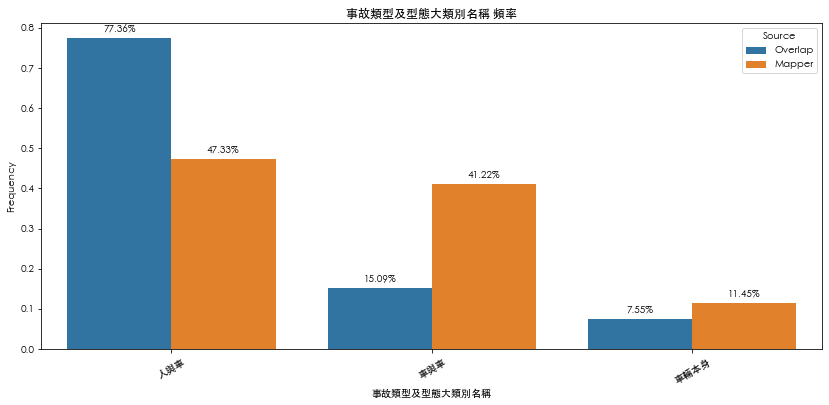

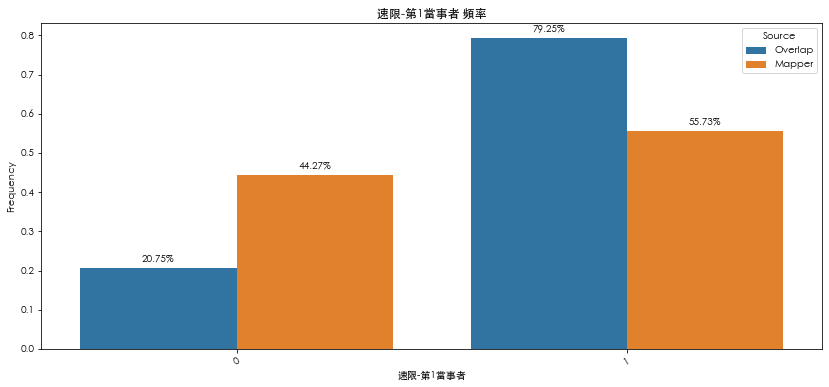

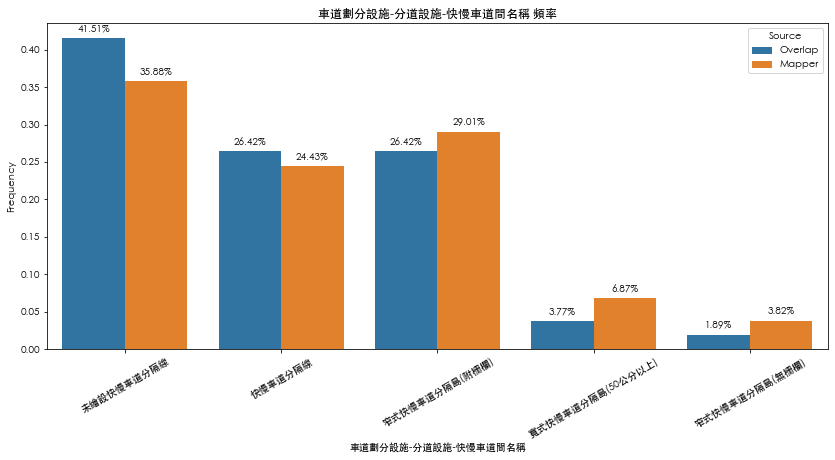

In [ ]:
plt.rcParams['font.sans-serif'] = ['STHeiti']
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Overlap'
    df2_counts['Source'] = 'Mapper'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=30)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    plt.show()

for feature in col:
    plot_bar_comparison(overlapping_rows, non_overlapping_rows_mapper, feature)

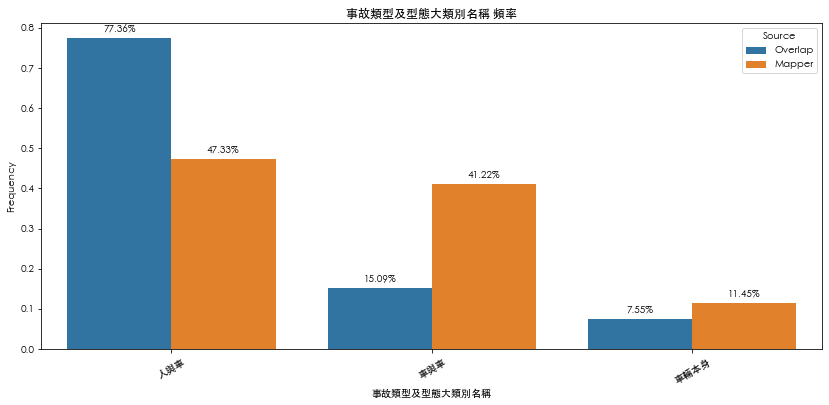

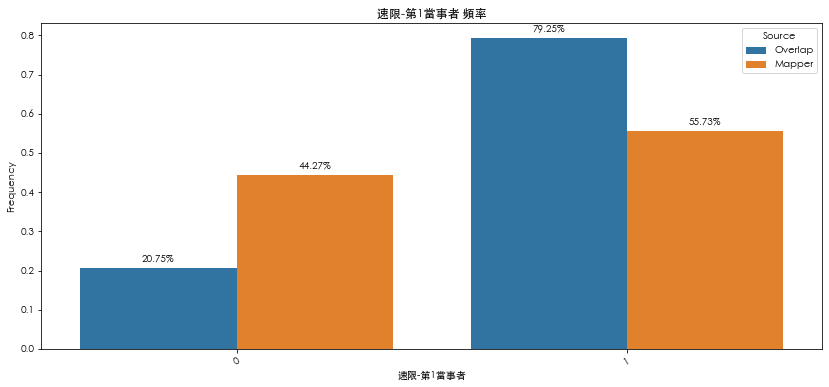

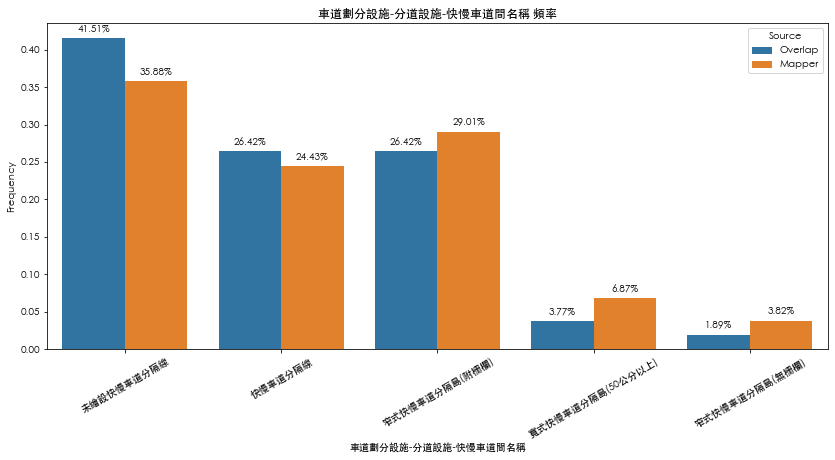

In [596]:
for feature in col:
    plot_bar_comparison(overlapping_rows, data_mapper, feature)

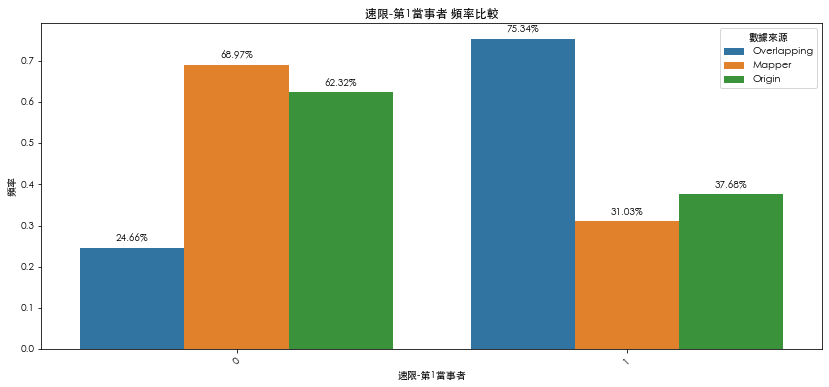

In [560]:
plot_bar_comparison(non_overlapping_rows_origin, non_overlapping_rows_mapper, overlapping_rows, '速限-第1當事者')

In [570]:
def plot_bar_comparison(df1, df2, df3, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    df3_counts = df3[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Origin'
    df2_counts['Source'] = 'Mapper'
    df3_counts['Source'] = 'Overlapping'

    combined_counts = pd.concat([df3_counts, df2_counts, df1_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']
    
    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率比較')
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel('頻率')
    plt.legend(title='數據來源')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    
    plt.show()

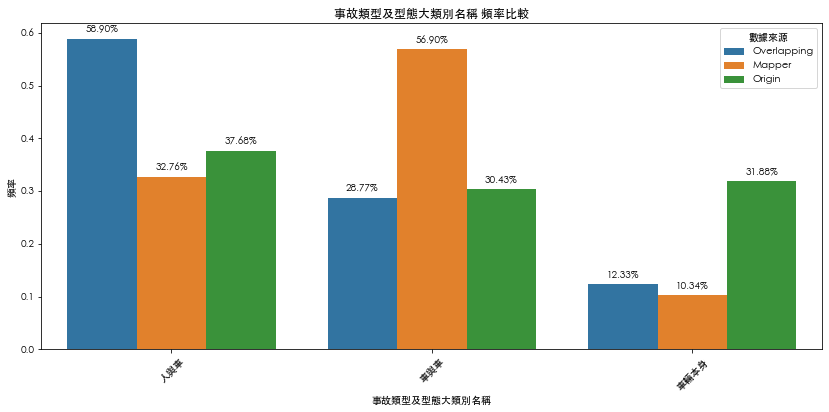

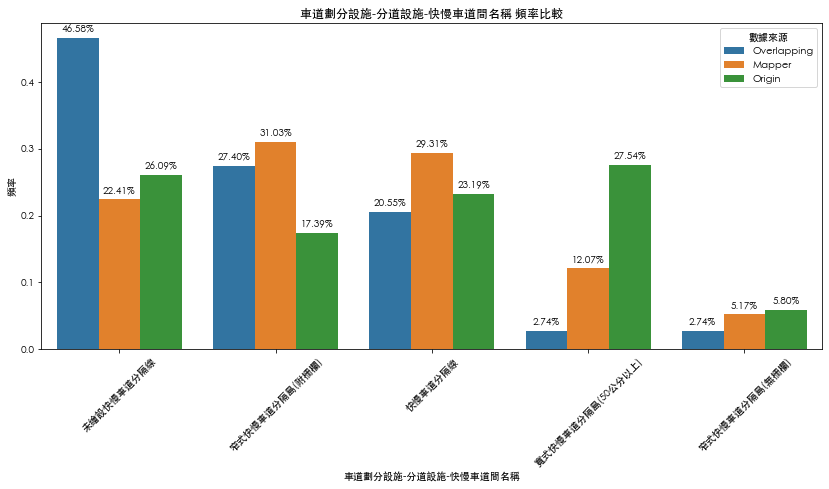

In [561]:
for feature in col:
    plot_bar_comparison(non_overlapping_rows_origin, non_overlapping_rows_mapper, overlapping_rows, feature)

## 離群最終，資料點抽樣以及離群點增加

In [700]:
data_origin = pd.read_csv('CalculatedData/離群比較/原始23.csv')
data_mapper = pd.read_csv('CalculatedData/離群比較/拓墣.csv')[data_origin.columns]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列做篩選
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(data_origin.shape)
print(data_mapper.shape)

overlapping_rows_mapper.shape[0] == overlapping_rows_origin.shape[0]

(142, 15)
(131, 15)


True

In [701]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)#.sample(sample).reset_index(drop=True)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 60000) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

rbind_data.head()

,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,經度,緯度,死亡,受傷
0,有照明未開啟或故障,省道,0,單路部分,其他,無號誌,中央分向島,車道線(附標記),快慢車道分隔線,有,車輛本身,120.533531,22.505826,1,0
1,無照明,市區道路,0,交岔路,交叉路口,閃光號誌,中央分向島,未繪設車道線,快慢車道分隔線,有,車與車,121.387116,24.938925,1,1
2,有照明且開啟,縣道,0,單路部分,路段,無號誌,雙向禁止超車線,車道線(無標記),快慢車道分隔線,有,車輛本身,119.641137,23.562740,1,0
3,有照明且開啟,市區道路,0,交岔路,交叉路口,閃光號誌,無,未繪設車道線,未繪設快慢車道分隔線,無,車與車,121.301528,24.974739,1,1
4,無照明,省道,0,單路部分,路段,無號誌,行車分向線,未繪設車道線,未繪設快慢車道分隔線,有,車輛本身,121.739574,24.264545,1,0


### remove Mapper outlier

In [698]:
logistic_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]
def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['死亡'] != 0 else 2, axis=1)
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y

### 原始資料去掉Mapper

In [691]:
overlapping_rows = pd.merge(rbind_data, data_mapper)

overlapping_index_rbind_data = rbind_data[rbind_data.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_data_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 獲取非重疊區域
non_overlapping_rows_rbind_data = rbind_data.loc[~rbind_data.index.isin(overlapping_index_rbind_data)].copy()
non_overlapping_rows_data_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_data_mapper)].copy()

mapper_X, mapper_y = get_clusterN_logit(non_overlapping_rows_rbind_data, logistic_lst)
matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)

score_mapper

0.6628571428571428

### 原始資料去掉Origin

In [692]:
overlapping_rows = pd.merge(rbind_data, data_origin)

overlapping_index_rbind_data = rbind_data[rbind_data.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_data_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 獲取非重疊區域
non_overlapping_rows_rbind_data = rbind_data.loc[~rbind_data.index.isin(overlapping_index_rbind_data)].copy()
non_overlapping_rows_data_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_data_origin)].copy()

mapper_X, mapper_y = get_clusterN_logit(non_overlapping_rows_rbind_data, logistic_lst)
matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)

score_mapper

0.6619318181818182

### 原始

In [694]:
mapper_X, mapper_y = get_clusterN_logit(rbind_data, logistic_lst)
matrix_mapper, score_mapper, cm_mapper = logistic_cm_gridsearch(mapper_X, mapper_y)

score_mapper

0.655367231638418